In [23]:
import pandas as pd
import subprocess
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset

In [5]:
file_path = 'breast-cancer-wisconsin.csv'
df = pd.read_csv(file_path)

In [6]:
df = df.drop('sample_code_number', axis=1)
df['class'] = df['class'].replace({2: 0, 4: 1}) # Replace 2,4 with 0,1 for clarity
df['bare_nuclei'] = pd.to_numeric(df['bare_nuclei'], errors='coerce') # Remove non numeric data (few rows)

In [7]:
info = df.info()

# Descriptive statistics
describe = df.describe()

# Check for missing values
missing_values = df.isnull().sum()

# Preview the first few rows
head = df.head()

print(df[df['class'] == 0].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   clump_thickness              699 non-null    int64  
 1   uniformity_of_cell_size      699 non-null    int64  
 2   uniformity_of_cell_shape     699 non-null    int64  
 3   marginal_adhesion            699 non-null    int64  
 4   single_epithelial_cell_size  699 non-null    int64  
 5   bare_nuclei                  683 non-null    float64
 6   bland_chromatin              699 non-null    int64  
 7   normal_nucleoli              699 non-null    int64  
 8   mitoses                      699 non-null    int64  
 9   class                        699 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 54.7 KB
<class 'pandas.core.frame.DataFrame'>
Index: 458 entries, 0 to 695
Data columns (total 10 columns):
 #   Column                       Non-Null Count

# Train-test split

In [ ]:
self_data = df[df['class'] == 0]

self_data_train, self_data_test = train_test_split(self_data, test_size=0.3, random_state=42)

# Save self data in a csv that will be used by C++
self_data_train.drop("class", axis=1).to_csv("self_data.csv", index=False, header=False)

In [ ]:
# Create X test and y test
non_self_data = df[df['class'] == 1]
X = pd.concat([non_self_data, self_data_test], ignore_index=True)

X_test = X.drop(columns="class")
y_test = X["class"]

# Testing detectors


In [ ]:
def average_absolute_distance(row_df1, df2, threshold):
    # Compute the absolute difference between row_df1 and each row in df2
    distances = np.abs(df2 - row_df1) / len(row_df1)
    # Sum the distances along the columns axis (axis=1)
    row_distances = distances.sum(axis=1)
    # Compute the average of these distances
    avg_distance = row_distances.mean()
    return 0 if avg_distance >= threshold else 1

def train (train_threshold, n_detectors, min_val, max_val):
    command = ['./detector', 'self_data.csv', 'detectors.csv', str(train_threshold), str(n_detectors),
               str(min_val), str(max_val)]
    print ("Getting detectors...")
    result = subprocess.run(command, capture_output=True, text=True)
    print ("Detectors generated")



train (4, 100, 1, 10)

Getting detectors...
Detectors generated


Accuracy: 0.9630606860158312
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       138
           1       0.96      0.99      0.97       241

    accuracy                           0.96       379
   macro avg       0.97      0.95      0.96       379
weighted avg       0.96      0.96      0.96       379

[[127  11]
 [  3 238]]


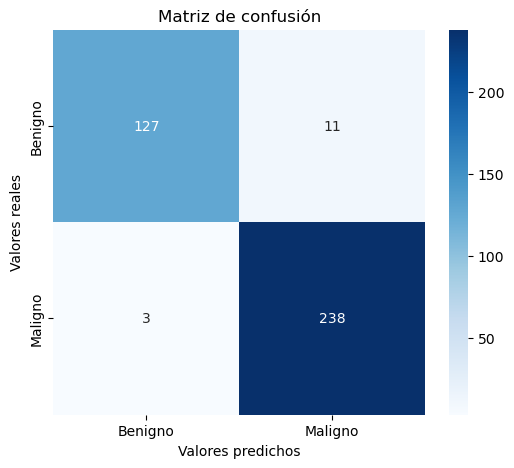

In [ ]:
def test (test_threshold):

    headers = [
        'clump_thickness',
        'uniformity_of_cell_size',
        'uniformity_of_cell_shape',
        'marginal_adhesion',
        'single_epithelial_cell_size',
        'bare_nuclei',
        'bland_chromatin',
        'normal_nucleoli',
        'mitoses'
    ]
    
    detectors = pd.read_csv("detectors.csv", header=None)
    detectors.columns = headers
    
    
    y_pred = X_test.apply(lambda row: average_absolute_distance(row, detectors, test_threshold), axis=1)
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

test(5.5)